In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tools import perform_pca
from tools import plot_transf_data
from tools import plot_comps,plot_comps_th, one_hot_nhts, plot_transf_data_electrics, plot_transf_data_electrics_one_comp 



## NTHS ##
Here we have an extraordinary amount of columns, which is why we extracted the most relevant ones, which we import from a global variable file. (In total 38 columns) 

In [17]:
### 1) Import selected columns that seem relevant. 
from gobal_vars import cols_veh, cols_hh, cols_per

### 2) Read dataframe with pre-selection of mentioned columns

url_veh="https://drive.google.com/file/d/1Bq1DuoWtd-JXIKLAebXJ_mQ-hO9ABgSm/view?usp=sharing" #downloading data/household_incomes
url_veh='https://drive.google.com/uc?id=' + url_veh.split('/')[-2]
url_hh = "https://drive.google.com/file/d/1ONB8fzNrdZc60mcJWxfYF3UOJTb7ZkL1/view?usp=sharing"
url_hh = 'https://drive.google.com/uc?id=' + url_hh.split('/')[-2]
url_per = "https://drive.google.com/file/d/1lnfhTNtnCirNvTBeQ5FNqyoU8zw-LE-d/view?usp=sharing"
url_per = 'https://drive.google.com/uc?id=' + url_per.split('/')[-2]
hh = pd.read_csv(url_hh)[cols_hh]
per = pd.read_csv(url_per) # [cols_per]
veh = pd.read_csv(url_veh)[cols_veh]

### basic stats: 
print(f'Amount of columns in household-table: {len(cols_hh)}')
print(f'Amount of columns in vehicle-table: {len(cols_veh)}')
print(f'Amount of columns in person-table: {len(cols_per)}')
print(f'Amount of rows in household-table: {len(hh)}')
print(f'Amount of rows in vehicle-table: {len(veh)}')
print(f'Amount of rows in person-table: {len(per)}')

Amount of columns in household-table: 17
Amount of columns in vehicle-table: 7
Amount of columns in person-table: 14
Amount of rows in household-table: 129696
Amount of rows in vehicle-table: 256115
Amount of rows in person-table: 264234


All this data can be joined on one household-id. In one household there can be a number of different persons as well as a number of different vehicles. Merging those thus enhances the number of rows again. We also extract only the samples taken from california. 

In [18]:
### 3) create dataframe which merges all of those columns together on HOUSEID
huge_merge = pd.merge(pd.merge(hh, per, on='HOUSEID'), veh, on='HOUSEID')
calif = huge_merge[(huge_merge['HHSTATE']=='CA')].drop(columns = ['HHSTATE'])
print(f'Total amount of columns: {len(calif.columns)}')
print(f'Total number of rows: {len(calif)}')

Total amount of columns: 36
Total number of rows: 122056


We have a lot of categorical data in this dataset. This needs to be one-hot-encoded before we're able to do anything significant. The reader can look into the function which is in the 'tools' file. Basically we back-encoded the numbers to the original category (using a dictionnary which is in the global_vars file), and afterwards used the python get_dummies function. 

In [19]:
### 4) one-hot-encode this dataframe
x_df = one_hot_nhts(calif)

# 3. Data Analysis # 
* talk about your machine learning
    In the NHTS we tried to use a classifier to predict if a person will own an electric car. This did not proof to be a very successfull approach. Specifically we noticed the precision was very low, it classified an enourmous amount of non-electric vehicles as electric. We decided that is not a useful insight and thus instead decided to perform a PCA to examine how EV owners compare one the central axes with regular vehicle owners.

In [20]:
### 5) get dataframe ready for PCA
df_pca = x_df.iloc[:, 2:].drop(columns = ['PERSONID'])
princ_comps, var_explained, transf_data, scaler = perform_pca(df_pca)


# 5 Visualizations #
* For the visualziation of the individual components, we decided to use a normal trend which shows the importance of the different variables for this component. Since there's a total of 89 variables (after one-hot-encoding), we choose a threshold of 0.1 to show only the most important one. On the website 

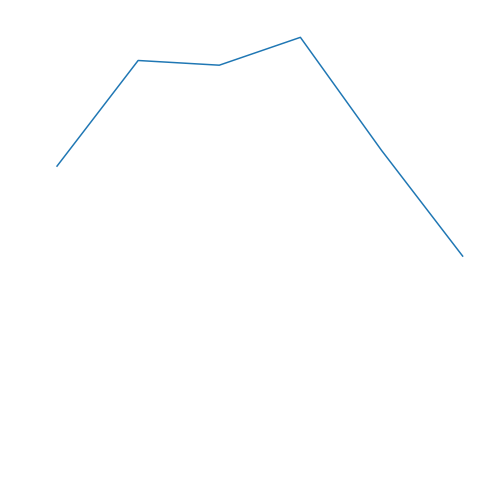

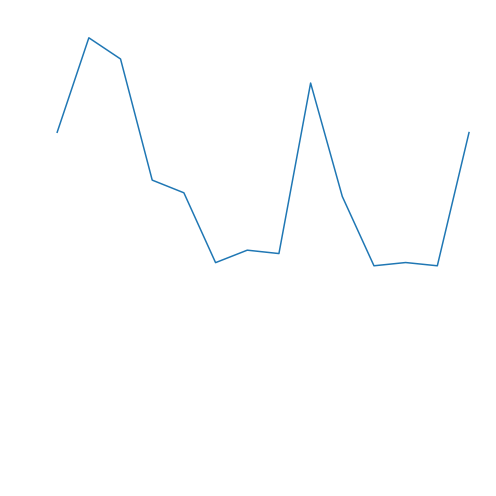

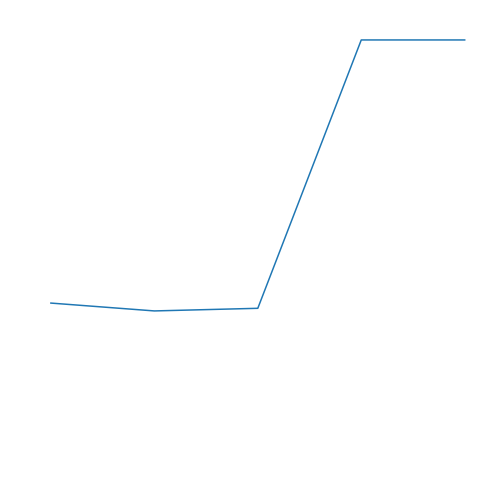

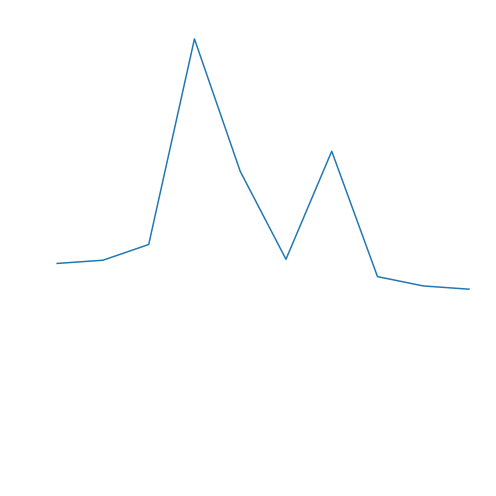

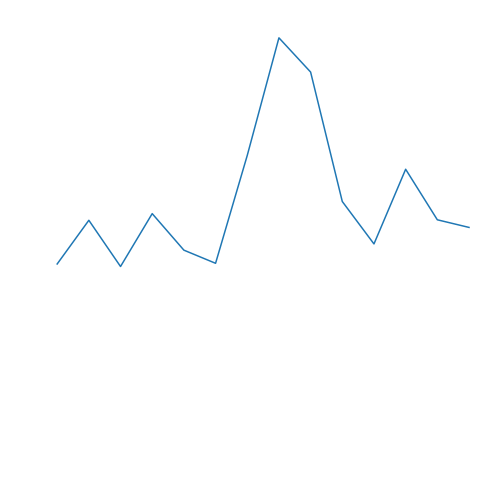

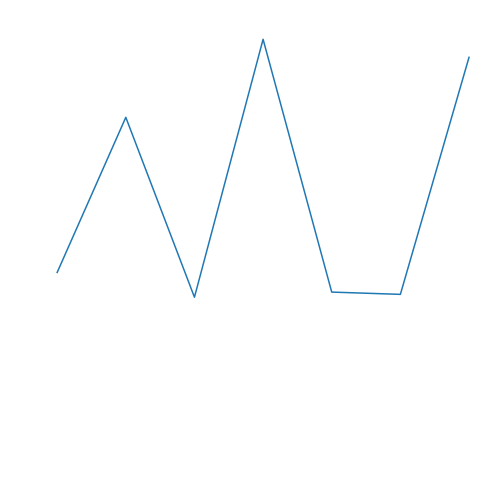

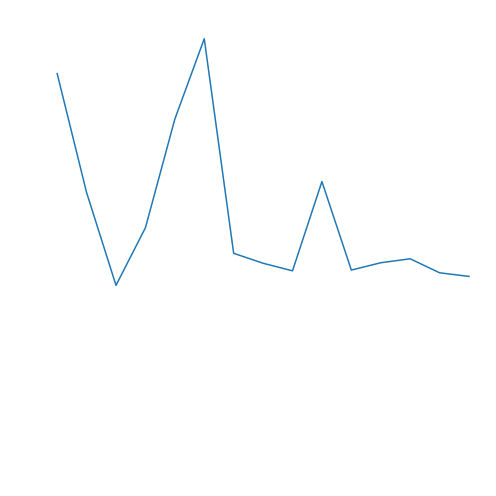

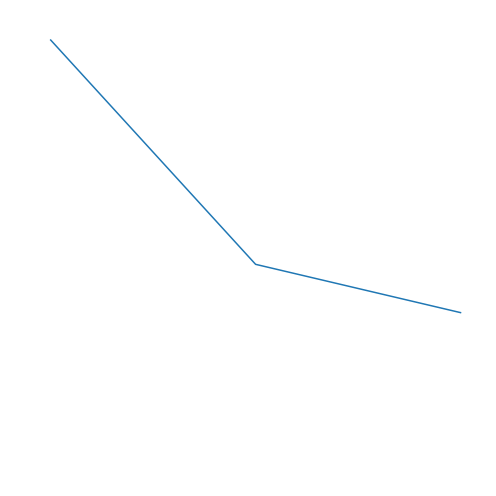

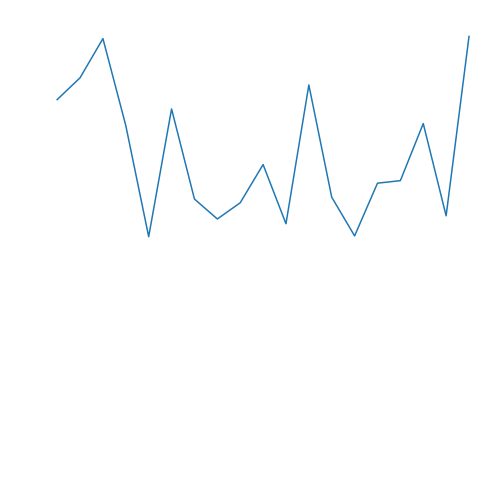

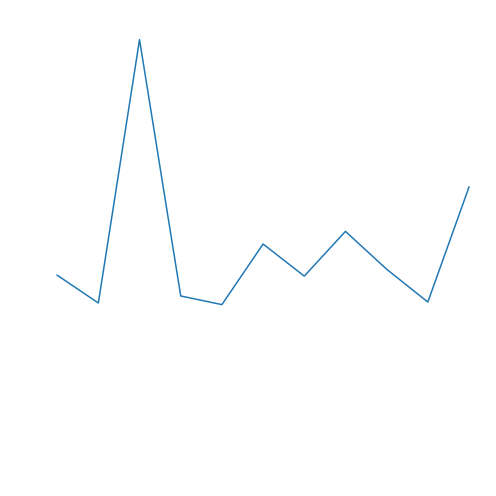

In [21]:
### 6) plot principal components using a threshold (here: 0.1)

params = {"text.color"  : "w",
          "ytick.color" : "w",
          "xtick.color" : "w",
          "xtick.labelsize"  : "8",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.autolayout" : "True"}
plt.rcParams.update(params)
for i in range(10):
    fig, ax = plot_comps_th(princ_comps, df_pca, i,0.1)
    plt.savefig(f'../docs/princ_comp{i+1}.png')


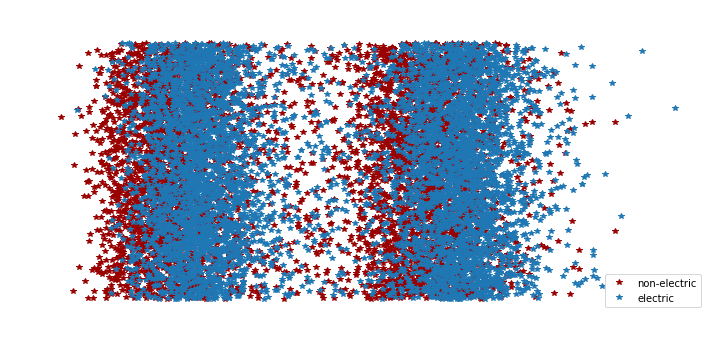

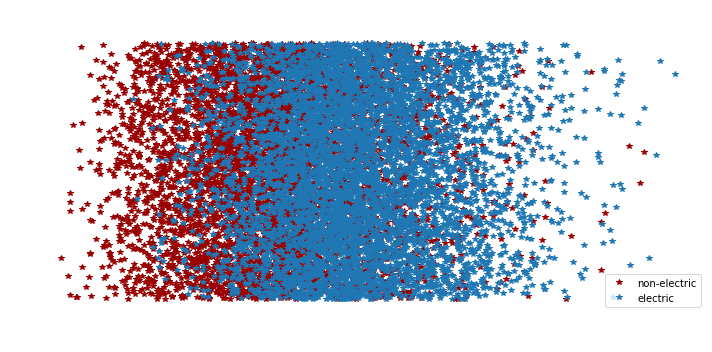

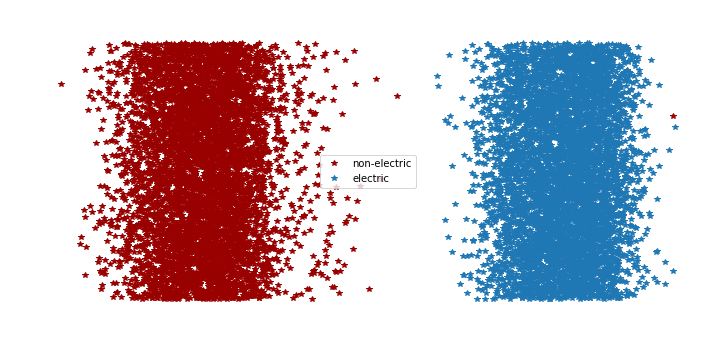

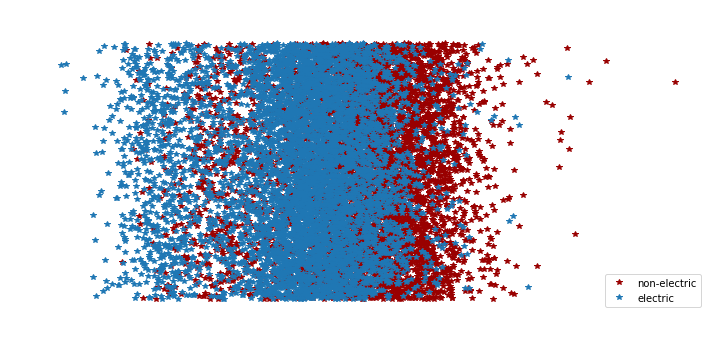

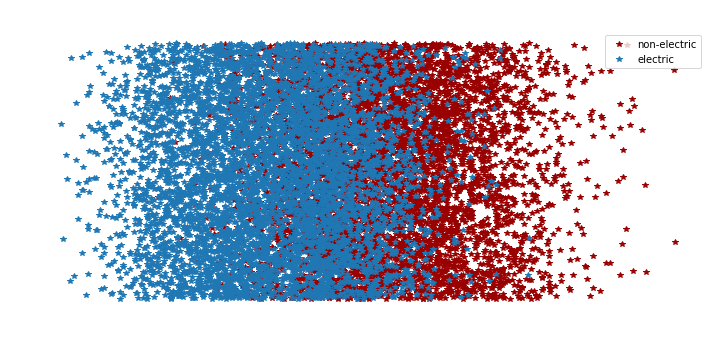

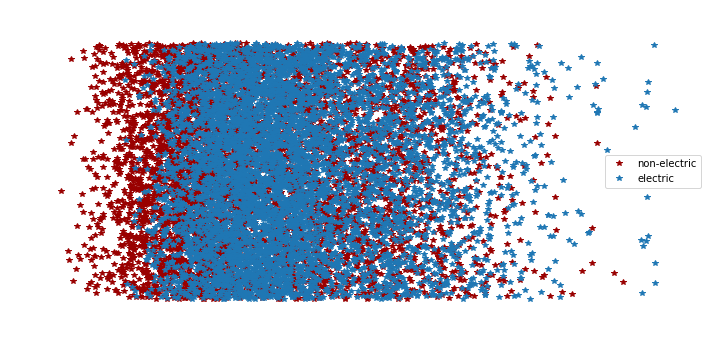

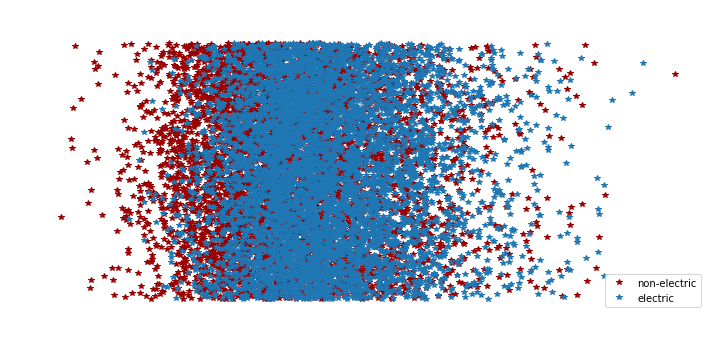

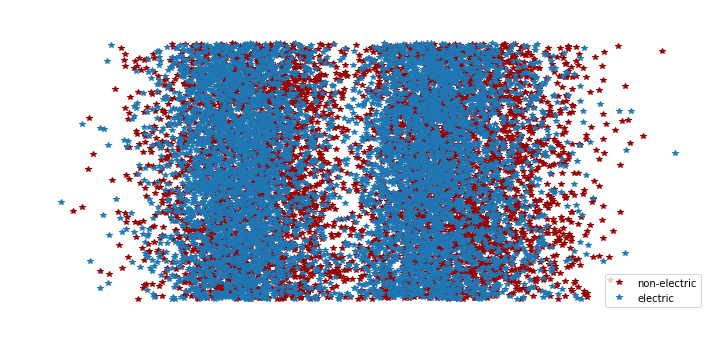

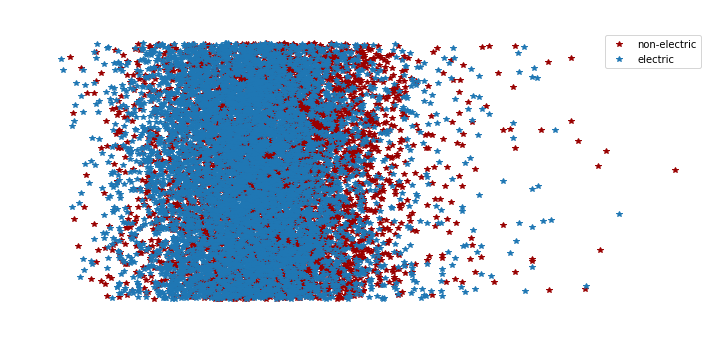

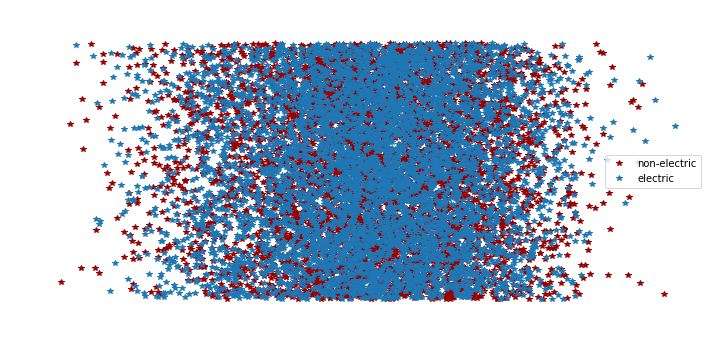

In [22]:
### 8) plot principal components as jitterplots with classes (EV/non-EV)

for i in range(10):
    fig, ax = plot_transf_data_electrics_one_comp(df_pca, transf_data, i)
    plt.savefig(f'../docs/princ_comp_classes{i+1}.png')


In [23]:
### split data in training and testing
from sklearn import model_selection
data = df_pca.drop(columns=['FUELTYPE_alternative_fuel', 'HYBRID_hybrid','HYBRID_no_hybrid', 'FUELTYPE_gas_fuel'])
target = df_pca.assign(el=(df_pca['FUELTYPE_alternative_fuel']==1).astype('category').cat.codes.values)['el']
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.30, random_state=42)

In [28]:
from sklearn.utils import resample 

train_data = pd.concat([X_train, y_train], axis=1)
non_el_ = train_data[train_data.el==0]
el_ = train_data[train_data.el==1]
pos_upsampled = resample(non_el_,
 replace=True, # sample with replacement
 n_samples=3*len(el_), # match number in majority class
 random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([el_, pos_upsampled])
# check new class counts
upsampled.el.value_counts()
X_train= upsampled.drop(columns = ['el'])
y_train= upsampled.el

In [25]:
### create a decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
clf = DecisionTreeClassifier(criterion="entropy")

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print( "Accuracy:",metrics.accuracy_score(y_test, y_pred))
print( "Precision:",metrics.precision_score(y_test, y_pred))
print( "Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7990277739847612
Precision: 0.15670356703567034
Recall: 0.7169386606640406


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print( "Accuracy:",metrics.accuracy_score(y_test, y_pred))
print( "Precision:",metrics.precision_score(y_test, y_pred))
print( "Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8855449654532048
Precision: 0.24286322965487858
Recall: 0.6415306696679798


Text(0.5, 1.0, 'Random forrest feature importance (only > 0.01)')

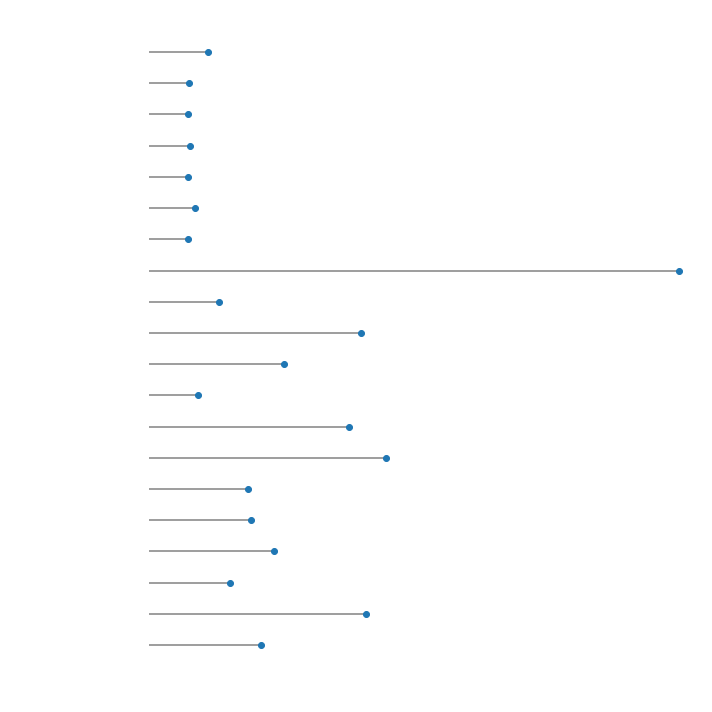

In [27]:
weights=model.feature_importances_
w_red = weights[weights>0.01]
X_test_red = X_test.columns[weights>0.01].values
fig, ax= plt.subplots(1,figsize=(10,10))
my_range=range(1,len(X_test_red)+1)
ax.hlines(y=X_test_red, xmin=0, xmax=w_red, color='grey')
ax.plot(w_red ,X_test_red, "o")   
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Random forrest feature importance (only > 0.01)')